/home/bertie/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


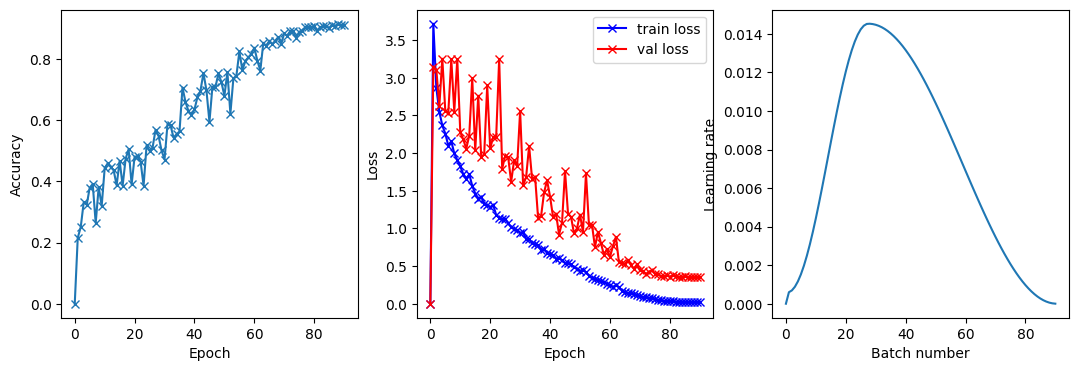

In [1]:
import pandas as pd
import misc

filename = 'resnet50_flowers_91.2acc_90epochs_onecycle'

csvroot = './output/'+ filename +'.csv'
history = pd.read_csv(csvroot)
misc.plot_history(history)

Load model

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils import show_batch, ToDeviceLoader
from models import models
from datasets import cub, flowers
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import config as cfg

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

dataset = eval(cfg.dataset)

datasets = dataset.get_datasets(download=False)

known = DataLoader(datasets['test_known'], batch_size=128,shuffle=False)
unknown = DataLoader(datasets['test_unknown'], batch_size=128,shuffle=False)

known = ToDeviceLoader(known, device)
unknown = ToDeviceLoader(unknown, device)

model = models.get_model(cfg.model, in_channels=3, num_classes=dataset.num_known_classes).to(device)
dictpath = './output/' + filename + '.pt'
model.load_state_dict(torch.load(dictpath))

Using cuda device


<All keys matched successfully>

Find average and binary predictions in-set softmax and out-set softmax

In [43]:
model.eval()

tau = 0.8
in_softmax_sum = 0
out_softmax_sum = 0

binary_preds = []
targets = []

for X,y in known:
    with torch.no_grad():
        pred = model(X)
        pred = F.softmax(pred, dim=1)
        max_softmax = torch.max(pred, dim=1)[0]
        bin = [1 if i >= tau else 0 for i in max_softmax] # 1=correctly identified as in-set (sm>tau)
        in_softmax_sum += torch.sum(max_softmax).item()
        binary_preds.extend(bin)
        targets.extend([1]*len(bin))
        
for X,y in unknown:
    with torch.no_grad():
        pred = model(X)
        pred = F.softmax(pred, dim=1)
        max_softmax = torch.max(pred, dim=1)[0]
        bin = [1 if i >= tau else 0 for i in max_softmax] # 0=correctly identified as out-set (sm<tau)
        out_softmax_sum += torch.sum(max_softmax).item()
        binary_preds.extend(bin)
        targets.extend([0]*len(bin))

in_softmax_mean = in_softmax_sum/len(datasets['test_known'])
out_softmax_mean = out_softmax_sum/len(datasets['test_unknown'])

roc_auc_score:  0.7291230701066768


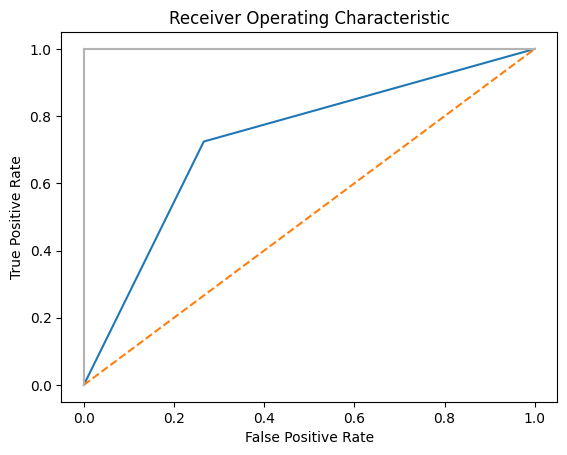

In [44]:


false_positive_rate, true_positive_rate, threshold = roc_curve(targets, binary_preds)

print('roc_auc_score: ', roc_auc_score(targets, binary_preds))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()